In [1]:
%load_ext watermark
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from myst_nb import glue
import statsmodels.api as sm
from scipy import stats

from plastockmethods import name_the_zones, name_the_particles, frequentation_name, situation_name
from plastockmethods import particle_groups, name_the_substrate, name_the_distance, table_css_styles

def translate_describe(x, value_column):
    described = x.to_dict()
    described.pop("count")
    described["moyenne"] = described.pop("mean")
    described["écart-type"] = described.pop("std")
    df = pd.DataFrame(described.items())
    df.set_index(0, inplace=True)
    df.rename(columns={1:value_column}, inplace=True)
    df.index.name = None
    
    
    return df

work_data = pd.read_csv("data/end_pipe/long_form_micro.csv")
wide_form = pd.read_csv("data/end_pipe/aggregated_micro_results.csv")
beach_data = pd.read_csv("data/end_pipe/asl_beaches.csv")

wdx = work_data.copy()
wdx["position"] = wdx.position.apply(lambda x: name_the_zones[x])
wdx["frequentation"] = wdx.frequentation.apply(lambda x: frequentation_name[x])
wdx["situation"] = wdx.situation.apply(lambda x: situation_name[x])
wdx["distance"] = wdx.distance.apply(lambda x: name_the_distance[x])
wdx["substrat"] = wdx.substrat.apply(lambda x: name_the_substrate[x])

# Regression

La position des échantillons sur la plage (ligne d'eau, plage-seche) représente différentes conditions d'échantillonnage. C'est pourquoi nous les traiterons séparément.

Les fragments durs et souple sont combinés pour chaque échantillon.

method = [statsmodels linear regression](https://www.statsmodels.org/stable/regression.html)

from the stasmodels: _Linear models with independently and identically distributed errors, and for errors with heteroscedasticity or autocorrelation. This module allows estimation by ordinary least squares (OLS), weighted least squares (WLS), generalized least squares (GLS), and feasible generalized least squares with autocorrelated AR(p) errors._

## Ligne d'eau

In [2]:
caption = "Les données sont regroupées en deux groupes par échantillon: 1. fibres, 2. fragment."

# separate the first zone
wdi = wdx[wdx.position == "ligne-d'eau"].copy()
scaled = (wdi["compte"] - wdi["compte"].min()) / (wdi["compte"].max() - wdi["compte"].min())
wdi["compte"] = scaled

# wdi["const"] = 1.0

# columns of interest
x_cols = ["orientation", "substrat", "frequentation", "situation", "distance", "objet"]
y_col = ["compte"]

# combine the fragments
w_fragments = wdi[wdi.objet.isin(["souple", "fdure"])].copy()

souple_d = w_fragments.groupby(["echantillon", *x_cols[:-1]], as_index=False).compte.sum()
souple_d["objet"] = "fragment"

# isolate the fibres
fibres = wdi[wdi.objet.isin(["fibres"])].copy()

# combine the aggregate fragments and the fibres
w_d = pd.concat([souple_d[[*x_cols, *y_col]], fibres[[*x_cols, *y_col]]])
w_d.to_csv("data/end_pipe/long_form_combined_formes.csv", index=False)

w_d.head().style.set_table_styles(table_css_styles).set_caption(caption)

,orientation,substrat,frequentation,situation,distance,objet,compte
0,NE,galet,élévée,campagne,< 100m,fragment,0.000000
1,NNE,galet,élévée,campagne,< 100m,fragment,0.024834
2,NE,galet,élévée,campagne,< 100m,fragment,0.000000
3,NNE,galet,élévée,campagne,< 100m,fragment,0.004967
4,NNO,galet,moyenne,campagne,< 100m,fragment,0.014901


### Régression des moindres carrés ordinaires (MCO)

__Toutes les variables__

In [3]:
# make dumby variables
x_dum = pd.get_dummies(w_d[x_cols], drop_first=True)

Y = w_d["compte"]

an_ols = sm.OLS(Y, x_dum)
ols_fit = an_ols.fit()
ols_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                 compte   R-squared (uncentered):                   0.553
Model:                            OLS   Adj. R-squared (uncentered):              0.496
Method:                 Least Squares   F-statistic:                              9.735
Date:                Thu, 12 Oct 2023   Prob (F-statistic):                    5.78e-23
Time:                        09:17:20   Log-Likelihood:                          178.31
No. Observations:                 222   AIC:                                     -306.6
Df Residuals:                     197   BIC:                                     -221.6
Df Model:                          25                                                  
Covariance Type:            nonrobust                                                  
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
orientation_ENE              0.2757      0.082      3.358      0.001       0.114       0.438
orientation_ESE              0.1694      0.113      1.502      0.135      -0.053       0.392
orientation_N                0.1039      0.065      1.587      0.114      -0.025       0.233
orientation_NE               0.1219      0.084      1.456      0.147      -0.043       0.287
orientation_NNE              0.1372      0.074      1.853      0.065      -0.009       0.283
orientation_NNO              0.0742      0.063      1.179      0.240      -0.050       0.198
orientation_NO               0.1901      0.064      2.982      0.003       0.064       0.316
orientation_O                0.1180      0.089      1.319      0.189      -0.058       0.294
orientation_ONO              0.1019      0.093      1.094      0.275      -0.082       0.286
orientation_OSO              0.1409      0.085      1.654      0.100      -0.027       0.309
orientation_S                0.1113      0.078      1.422      0.157      -0.043       0.266
orientation_SE               0.1689      0.061      2.750      0.007       0.048       0.290
orientation_SO               0.1907      0.075      2.534      0.012       0.042       0.339
orientation_SSE              0.0864      0.076      1.133      0.259      -0.064       0.237
orientation_SSO              0.1188      0.076      1.567      0.119      -0.031       0.268
substrat_gravier            -0.0048      0.046     -0.103      0.918      -0.096       0.086
substrat_sable fin           0.0619      0.026      2.381      0.018       0.011       0.113
substrat_sable grosssier    -0.0312      0.043     -0.731      0.466      -0.116       0.053
frequentation_moyenne        0.0623      0.051      1.210      0.228      -0.039       0.164
frequentation_élévée        -0.0359      0.069     -0.522      0.602      -0.172       0.100
situation_urbain            -0.0089      0.034     -0.262      0.794      -0.076       0.058
distance_500 - 1000m         0.0185      0.108      0.172      0.864      -0.194       0.231
distance_< 100m              0.0081      0.025      0.330      0.742      -0.040       0.057
distance_> 1000m            -0.0858      0.063     -1.359      0.176      -0.210       0.039
objet_fragment              -0.0930      0.015     -6.030      0.000      -0.123      -0.063
==============================================================================
Omnibus:                      234.304   Durbin-Watson:                   1.736
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8583.985
Skew:                           4.162   Prob(JB):                         0.00
Kurtosis:                      32.304   Cond. No.               

__Residuals__

Dans la régression linéaire, un _residual_ est la différence entre la valeur réelle et la valeur prédite par le modèle (y-ŷ) pour un point donné. Un modèle de régression des moindres carrés minimise la somme des carrés des résidus

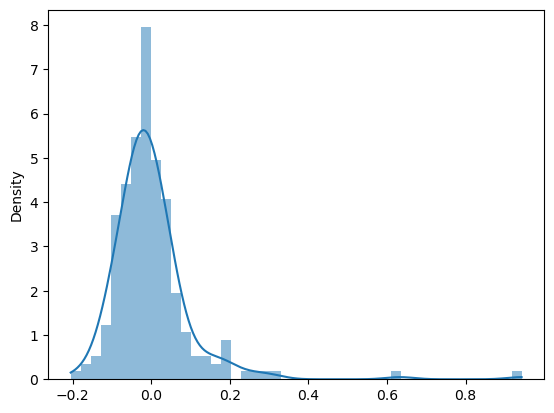

In [4]:
fig, ax = plt.subplots()
sns.histplot(x=ols_fit.resid, ax=ax, stat="density", linewidth=0, kde=True)
plt.show()

#### QQ plot

Un graphique q-q est un graphique des quantiles du premier ensemble de données par rapport aux quantiles du second ensemble de données. Par quantile, nous entendons la fraction (ou le pourcentage) de points inférieurs à la valeur donnée. Ainsi, le quantile 0,3 (ou 30 %) est le point auquel 30 % des données sont inférieures et 70 % supérieures à cette valeur.

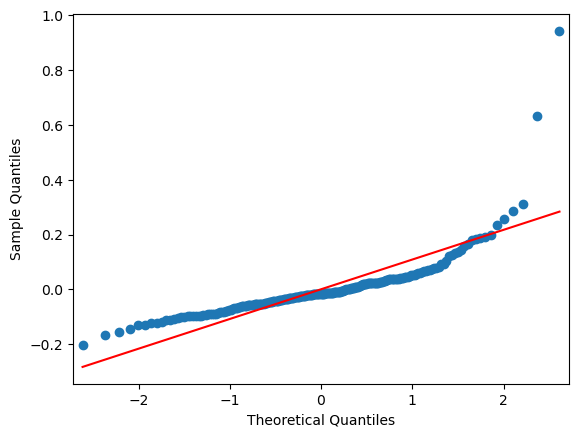

In [5]:
sm.qqplot(ols_fit.resid, line='s');

#### Hsitogram

Histogramme des observations par rapport aux prévisions. Résultats limités à > 0

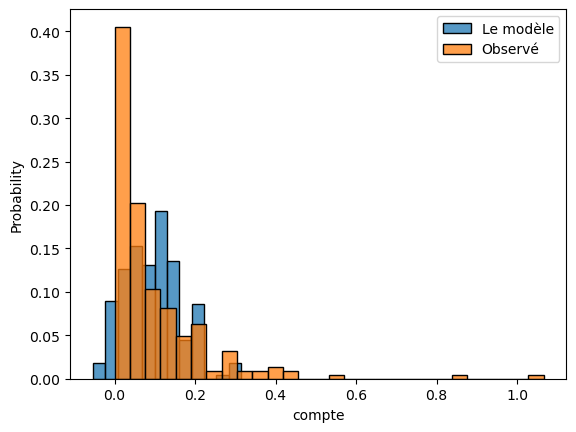

In [6]:
Y_max = Y.max()
Y_min = Y.min()

ax = sns.histplot(ols_fit.fittedvalues, label="Le modèle", stat="probability")
ax = sns.histplot(Y, label="Observé", stat="probability")

ax.legend()
plt.show()

#### Sans la variable d'orientation

In [7]:
# make dumby variables

x_dum = pd.get_dummies(w_d[x_cols[1:]], drop_first=True)
Y = w_d["compte"]

an_ols = sm.OLS(Y, x_dum)
ols_fit = an_ols.fit()
ols_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                 compte   R-squared (uncentered):                   0.483
Model:                            OLS   Adj. R-squared (uncentered):              0.459
Method:                 Least Squares   F-statistic:                              19.80
Date:                Thu, 12 Oct 2023   Prob (F-statistic):                    1.40e-25
Time:                        09:17:20   Log-Likelihood:                          162.25
No. Observations:                 222   AIC:                                     -304.5
Df Residuals:                     212   BIC:                                     -270.5
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
substrat_gravier             0.0302      0.026      1.160      0.247      -0.021       0.081
substrat_sable fin           0.0893      0.021      4.282      0.000       0.048       0.130
substrat_sable grosssier     0.0402      0.031      1.304      0.194      -0.021       0.101
frequentation_moyenne        0.1494      0.023      6.556      0.000       0.105       0.194
frequentation_élévée         0.0907      0.023      3.963      0.000       0.046       0.136
situation_urbain            -0.0335      0.020     -1.708      0.089      -0.072       0.005
distance_500 - 1000m         0.0511      0.069      0.742      0.459      -0.085       0.187
distance_< 100m             -0.0008      0.017     -0.046      0.964      -0.035       0.033
distance_> 1000m             0.0063      0.034      0.188      0.851      -0.060       0.072
objet_fragment              -0.0861      0.016     -5.422      0.000      -0.117      -0.055
==============================================================================
Omnibus:                      225.668   Durbin-Watson:                   1.684
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6792.683
Skew:                           4.003   Prob(JB):                         0.00
Kurtosis:                      28.889   Cond. No.                         11.2
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### QQ plot

Un graphique q-q est un graphique des quantiles du premier ensemble de données par rapport aux quantiles du second ensemble de données. Par quantile, nous entendons la fraction (ou le pourcentage) de points inférieurs à la valeur donnée. Ainsi, le quantile 0,3 (ou 30 %) est le point auquel 30 % des données sont inférieures et 70 % supérieures à cette valeur.

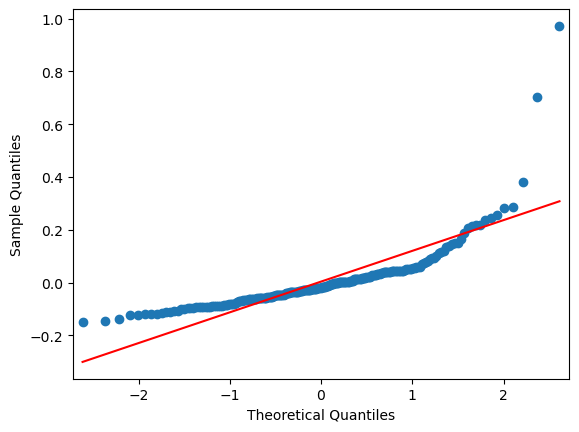

In [8]:
sm.qqplot(ols_fit.resid, line='s');

#### Sans la variable de frequentation

In [9]:
x_cols = ["orientation", "substrat", "situation", "objet", "situation", "distance"]

# make dumby variables
x_dum = pd.get_dummies(w_d[x_cols], drop_first=True)
Y = w_d["compte"]

an_ols = sm.OLS(Y, x_dum)
ols_fit = an_ols.fit()
ols_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                 compte   R-squared (uncentered):                   0.537
Model:                            OLS   Adj. R-squared (uncentered):              0.483
Method:                 Least Squares   F-statistic:                              10.02
Date:                Thu, 12 Oct 2023   Prob (F-statistic):                    1.32e-22
Time:                        09:17:20   Log-Likelihood:                          174.40
No. Observations:                 222   AIC:                                     -302.8
Df Residuals:                     199   BIC:                                     -224.5
Df Model:                          23                                                  
Covariance Type:            nonrobust                                                  
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
orientation_ENE              0.2373      0.079      3.010      0.003       0.082       0.393
orientation_ESE              0.0883      0.060      1.462      0.145      -0.031       0.208
orientation_N                0.1302      0.041      3.213      0.002       0.050       0.210
orientation_NE               0.0799      0.040      2.009      0.046       0.001       0.158
orientation_NNE              0.1324      0.046      2.902      0.004       0.042       0.222
orientation_NNO              0.1327      0.038      3.455      0.001       0.057       0.208
orientation_NO               0.2123      0.032      6.617      0.000       0.149       0.276
orientation_O                0.0822      0.049      1.680      0.094      -0.014       0.179
orientation_ONO              0.0673      0.055      1.229      0.221      -0.041       0.175
orientation_OSO              0.1034      0.040      2.597      0.010       0.025       0.182
orientation_S                0.1113      0.054      2.072      0.040       0.005       0.217
orientation_SE               0.1548      0.048      3.254      0.001       0.061       0.249
orientation_SO               0.1596      0.034      4.657      0.000       0.092       0.227
orientation_SSE              0.0890      0.048      1.856      0.065      -0.006       0.183
orientation_SSO              0.1165      0.055      2.124      0.035       0.008       0.225
substrat_gravier             0.0394      0.037      1.080      0.281      -0.033       0.111
substrat_sable fin           0.0641      0.026      2.485      0.014       0.013       0.115
substrat_sable grosssier    -0.0805      0.037     -2.177      0.031      -0.153      -0.008
situation_urbain            -0.0240      0.013     -1.811      0.072      -0.050       0.002
objet_fragment              -0.0911      0.016     -5.842      0.000      -0.122      -0.060
situation_urbain            -0.0240      0.013     -1.811      0.072      -0.050       0.002
distance_500 - 1000m         0.0719      0.075      0.962      0.337      -0.075       0.219
distance_< 100m              0.0114      0.025      0.458      0.648      -0.038       0.061
distance_> 1000m             0.0010      0.042      0.024      0.981      -0.083       0.085
==============================================================================
Omnibus:                      229.463   Durbin-Watson:                   1.671
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7584.568
Skew:                           4.068   Prob(JB):                         0.00
Kurtosis:                      30.454   Cond. No.                     5.75e+16
==============================================================================

#### QQ plot

Un graphique q-q est un graphique des quantiles du premier ensemble de données par rapport aux quantiles du second ensemble de données. Par quantile, nous entendons la fraction (ou le pourcentage) de points inférieurs à la valeur donnée. Ainsi, le quantile 0,3 (ou 30 %) est le point auquel 30 % des données sont inférieures et 70 % supérieures à cette valeur.

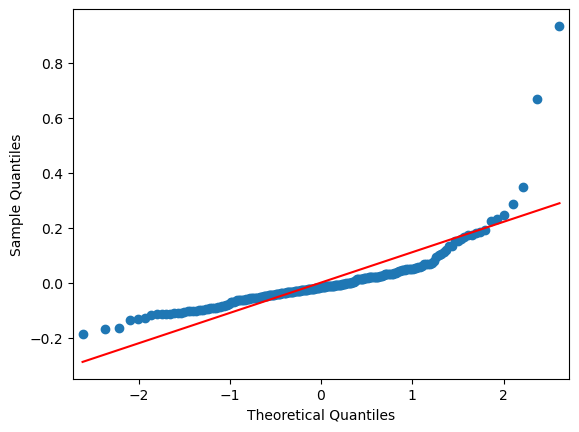

In [10]:
sm.qqplot(ols_fit.resid, line='s');

## Plage seche

In [12]:
# separate the first zone
x_cols = ["orientation", "substrat", "frequentation", "situation", "distance", "objet"]
wdi = wdx[wdx.position == "plage-seche"].copy()
# wdx["const"] = 1
scaled = (wdi["compte"] - wdi["compte"].min()) / (wdi["compte"].max() - wdi["compte"].min())
wdi["compte"] = scaled

# combine the fragments
w_f = wdi[wdi.objet.isin(["souple", "fdure"])].copy()
souple_d = w_f.groupby(["echantillon", *x_cols[:-1]], as_index=False).compte.sum()
souple_d["objet"] = "fragment"

# isolate the fibres
fibres = wdi[wdi.objet.isin(["fibres"])].copy()

# combine the aggregate fragments and the fibres
w_d = pd.concat([souple_d[[*x_cols, *y_col]], fibres[[*x_cols, *y_col]]])

w_d.head().style.set_table_styles(table_css_styles).set_caption(caption)

,orientation,substrat,frequentation,situation,distance,objet,compte
0,NNE,galet,élévée,campagne,< 100m,fragment,0.023911
1,NE,galet,élévée,campagne,< 100m,fragment,0.005013
2,NE,galet,élévée,campagne,< 100m,fragment,0.008099
3,NE,galet,élévée,campagne,< 100m,fragment,0.004242
4,NNE,galet,élévée,campagne,< 100m,fragment,0.001928


### Régression des moindres carrés ordinaires (MCO)

__Toutes les variables__

In [13]:
# make dumby variables
x_dum = pd.get_dummies(w_d[x_cols], drop_first=True)
Y = w_d["compte"]

an_ols = sm.OLS(Y, x_dum)
ols_fit = an_ols.fit()
ols_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                 compte   R-squared (uncentered):                   0.542
Model:                            OLS   Adj. R-squared (uncentered):              0.489
Method:                 Least Squares   F-statistic:                              10.21
Date:                Thu, 12 Oct 2023   Prob (F-statistic):                    4.32e-22
Time:                        09:18:12   Log-Likelihood:                          274.35
No. Observations:                 212   AIC:                                     -504.7
Df Residuals:                     190   BIC:                                     -430.9
Df Model:                          22                                                  
Covariance Type:            nonrobust                                                  
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
orientation_N                0.0086      0.049      0.176      0.860      -0.087       0.104
orientation_NE               0.0369      0.046      0.805      0.422      -0.054       0.127
orientation_NNE              0.0218      0.048      0.452      0.652      -0.073       0.117
orientation_NNO             -0.0689      0.066     -1.038      0.301      -0.200       0.062
orientation_NO               0.0110      0.055      0.201      0.841      -0.097       0.119
orientation_O                0.0656      0.048      1.368      0.173      -0.029       0.160
orientation_ONO              0.0016      0.049      0.033      0.974      -0.096       0.099
orientation_OSO             -0.0816      0.049     -1.673      0.096      -0.178       0.015
orientation_S                0.0601      0.054      1.105      0.271      -0.047       0.167
orientation_SE               0.0228      0.068      0.336      0.738      -0.111       0.157
orientation_SO               0.0248      0.039      0.632      0.528      -0.053       0.102
orientation_SSE             -0.0105      0.059     -0.177      0.860      -0.128       0.107
orientation_SSO              0.0241      0.062      0.386      0.700      -0.099       0.147
substrat_gravier             0.1321      0.027      4.805      0.000       0.078       0.186
substrat_sable fin          -0.0053      0.023     -0.228      0.820      -0.051       0.041
substrat_sable grosssier     0.0243      0.042      0.583      0.561      -0.058       0.106
frequentation_moyenne        0.1376      0.051      2.719      0.007       0.038       0.237
frequentation_élévée         0.0363      0.038      0.952      0.342      -0.039       0.112
situation_urbain             0.0020      0.021      0.096      0.924      -0.039       0.043
distance_< 100m             -0.0079      0.019     -0.422      0.673      -0.045       0.029
distance_> 1000m            -0.0279      0.050     -0.556      0.579      -0.127       0.071
objet_fragment              -0.0548      0.010     -5.705      0.000      -0.074      -0.036
==============================================================================
Omnibus:                      268.407   Durbin-Watson:                   2.110
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            23582.024
Skew:                           5.152   Prob(JB):                         0.00
Kurtosis:                      53.631   Cond. No.                         53.3
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly s

__Residuals__

Dans la régression linéaire, un _residual_ est la différence entre la valeur réelle et la valeur prédite par le modèle (y-ŷ) pour un point donné. Un modèle de régression des moindres carrés minimise la somme des carrés des résidus

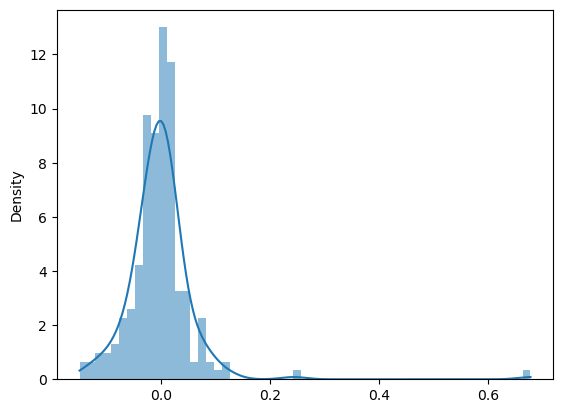

In [14]:
fig, ax = plt.subplots()
sns.histplot(x=ols_fit.resid, ax=ax, stat="density", linewidth=0, kde=True)
plt.show()

#### QQ plot

Un graphique q-q est un graphique des quantiles du premier ensemble de données par rapport aux quantiles du second ensemble de données. Par quantile, nous entendons la fraction (ou le pourcentage) de points inférieurs à la valeur donnée. Ainsi, le quantile 0,3 (ou 30 %) est le point auquel 30 % des données sont inférieures et 70 % supérieures à cette valeur.

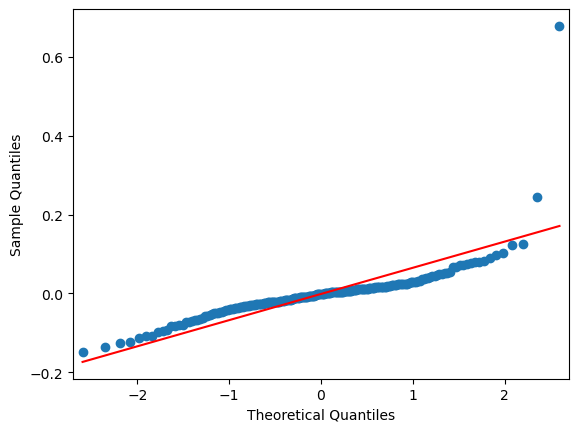

In [15]:
sm.qqplot(ols_fit.resid, line='s');

#### Histogram

Histogramme des observations par rapport aux prévisions. Résultats limités à > 0

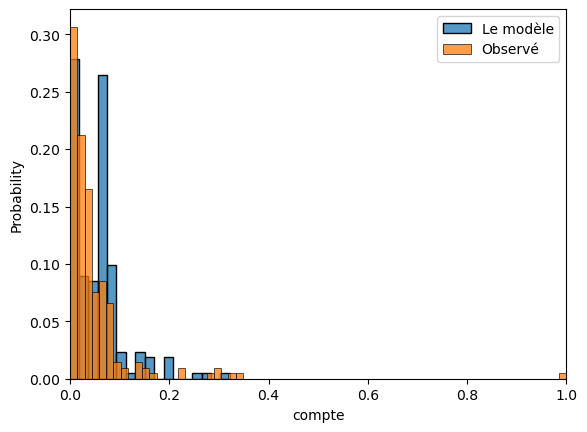

In [16]:
Y_max = Y.max()
Y_min = Y.min()

ax = sns.histplot(ols_fit.fittedvalues, label="Le modèle", stat="probability")
ax = sns.histplot(Y, label="Observé", stat="probability")
# ax.set(ylim=(Y_min, Y_max+10))
ax.set(xlim=(0, 1))
ax.legend()
plt.show()

#### Sans la variable d'orientation

In [17]:
# make dumby variables
x_dum = pd.get_dummies(w_d[x_cols[1:]], drop_first=True)
Y = w_d["compte"]

an_ols = sm.OLS(Y, x_dum)
ols_fit = an_ols.fit()
ols_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                 compte   R-squared (uncentered):                   0.468
Model:                            OLS   Adj. R-squared (uncentered):              0.444
Method:                 Least Squares   F-statistic:                              19.83
Date:                Thu, 12 Oct 2023   Prob (F-statistic):                    1.12e-23
Time:                        09:18:12   Log-Likelihood:                          258.48
No. Observations:                 212   AIC:                                     -499.0
Df Residuals:                     203   BIC:                                     -468.8
Df Model:                           9                                                  
Covariance Type:            nonrobust                                                  
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
substrat_gravier             0.1221      0.022      5.572      0.000       0.079       0.165
substrat_sable fin           0.0271      0.018      1.468      0.144      -0.009       0.063
substrat_sable grosssier     0.0374      0.022      1.693      0.092      -0.006       0.081
frequentation_moyenne        0.1128      0.021      5.448      0.000       0.072       0.154
frequentation_élévée         0.0329      0.020      1.677      0.095      -0.006       0.072
situation_urbain            -0.0056      0.012     -0.478      0.633      -0.029       0.017
distance_< 100m              0.0038      0.010      0.365      0.715      -0.017       0.024
distance_> 1000m            -0.0571      0.036     -1.585      0.114      -0.128       0.014
objet_fragment              -0.0544      0.010     -5.441      0.000      -0.074      -0.035
==============================================================================
Omnibus:                      296.386   Durbin-Watson:                   1.916
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            33213.036
Skew:                           6.082   Prob(JB):                         0.00
Kurtosis:                      63.100   Cond. No.                         12.0
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### QQ plot

Un graphique q-q est un graphique des quantiles du premier ensemble de données par rapport aux quantiles du second ensemble de données. Par quantile, nous entendons la fraction (ou le pourcentage) de points inférieurs à la valeur donnée. Ainsi, le quantile 0,3 (ou 30 %) est le point auquel 30 % des données sont inférieures et 70 % supérieures à cette valeur.

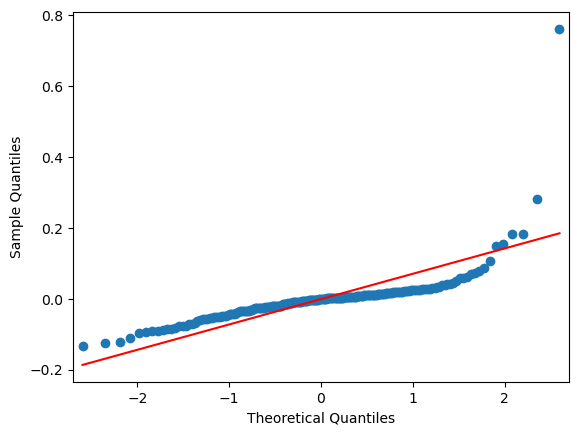

In [18]:
sm.qqplot(ols_fit.resid, line='s');

#### Sans la variable de distance

In [19]:
x_cols = ["orientation", "substrat", "situation", "objet", "situation", "distance"]

# make dumby variables
x_dum = pd.get_dummies(w_d[x_cols], drop_first=True)
Y = w_d["compte"]

an_ols = sm.OLS(Y, x_dum)
ols_fit = an_ols.fit()
ols_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                 compte   R-squared (uncentered):                   0.519
Model:                            OLS   Adj. R-squared (uncentered):              0.469
Method:                 Least Squares   F-statistic:                              10.35
Date:                Thu, 12 Oct 2023   Prob (F-statistic):                    2.84e-21
Time:                        09:18:12   Log-Likelihood:                          269.16
No. Observations:                 212   AIC:                                     -498.3
Df Residuals:                     192   BIC:                                     -431.2
Df Model:                          20                                                  
Covariance Type:            nonrobust                                                  
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
orientation_N                0.1087      0.026      4.107      0.000       0.057       0.161
orientation_NE               0.1020      0.028      3.682      0.000       0.047       0.157
orientation_NNE              0.0885      0.028      3.117      0.002       0.032       0.144
orientation_NNO              0.0892      0.035      2.582      0.011       0.021       0.157
orientation_NO               0.1246      0.036      3.504      0.001       0.054       0.195
orientation_O                0.1129      0.037      3.074      0.002       0.040       0.185
orientation_ONO              0.0504      0.038      1.330      0.185      -0.024       0.125
orientation_OSO             -0.0284      0.035     -0.820      0.413      -0.097       0.040
orientation_S                0.1621      0.035      4.652      0.000       0.093       0.231
orientation_SE               0.1533      0.050      3.046      0.003       0.054       0.253
orientation_SO               0.0788      0.024      3.230      0.001       0.031       0.127
orientation_SSE              0.1086      0.039      2.787      0.006       0.032       0.185
orientation_SSO              0.1458      0.042      3.452      0.001       0.062       0.229
substrat_gravier             0.1487      0.027      5.456      0.000       0.095       0.202
substrat_sable fin          -0.0165      0.022     -0.752      0.453      -0.060       0.027
substrat_sable grosssier    -0.0358      0.035     -1.035      0.302      -0.104       0.032
situation_urbain            -0.0161      0.009     -1.812      0.072      -0.034       0.001
objet_fragment              -0.0545      0.010     -5.570      0.000      -0.074      -0.035
situation_urbain            -0.0161      0.009     -1.812      0.072      -0.034       0.001
distance_< 100m             -0.0286      0.018     -1.600      0.111      -0.064       0.007
distance_> 1000m             0.0578      0.042      1.374      0.171      -0.025       0.141
==============================================================================
Omnibus:                      284.248   Durbin-Watson:                   2.187
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            30502.454
Skew:                           5.632   Prob(JB):                         0.00
Kurtosis:                      60.673   Cond. No.                     2.31e+16
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The smallest eigenvalue is 6.03e-31. This might indicate that there are
strong 

#### QQ plot

Un graphique q-q est un graphique des quantiles du premier ensemble de données par rapport aux quantiles du second ensemble de données. Par quantile, nous entendons la fraction (ou le pourcentage) de points inférieurs à la valeur donnée. Ainsi, le quantile 0,3 (ou 30 %) est le point auquel 30 % des données sont inférieures et 70 % supérieures à cette valeur.

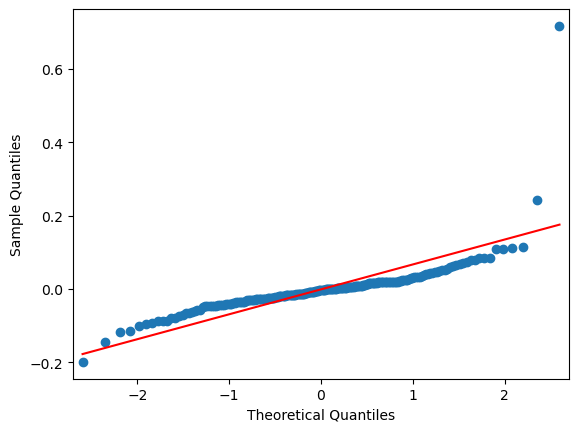

In [20]:
sm.qqplot(ols_fit.resid, line='s');

In [21]:
%watermark --iversions -b -r

Git repo: https://github.com/hammerdirt-analyst/plastock.git

Git branch: glm_p

seaborn    : 0.12.2
matplotlib : 3.7.1
scipy      : 1.10.1
statsmodels: 0.13.5
pandas     : 2.0.0
numpy      : 1.24.2



In [22]:
# from sklearn.compose import make_column_selector as selector
# numerical_columns_selector = selector(dtype_exclude=object)
# categorical_columns_selector = selector(dtype_include=object)

# regressors = ["orientation", "substrat", "frequentation", "situatation", "distance", "objet"] 

# numerical_columns = numerical_columns_selector(data)
# categorical_columns = categorical_columns_selector(data)